In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import numpy as np
import pandas as pd

from tracking_data.dataset import Dataset_TailTracking,Dataset_CentroidTracking
from pipeline.cfg import ConfigTrajPreprocess,ConfigTrajSegmentationClassification
from pipeline.centroid_tracking import  PipelineCentroidTracking

from utils.utils_plot import display_trajectory
from utils.utils import compute_outer_circle
from utils import smallestenclosingcircle as smallestenclosingcircle
from super_resolution.downsampling import convert_frame_duration,create_downsampling_function

from utils.utils_bouts import NameCat

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors


from utils.utils_bouts import compute_bout_cat_ts
from classification.benchmark_w_matlab import compute_bout_cat_matlab
from scipy import stats


## Load Dataset:

In [91]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)


# Load Gold standard 

In [92]:
import pickle


filename = 'G://Megabouts_dataset//Full_Tracking_Pipeline//CatchAllBouts_atlas_20200525_1551.pickle'

with open(filename, 'rb') as handle:
            pipeline_results = pickle.load(handle)

# Extract Python Results
pipeline_results_full_tracking = pipeline_results['pipeline']

segments_full = pipeline_results_full_tracking['segments']
bout_cat_full = pipeline_results_full_tracking['bout_cat']
onset_full = segments_full.onset
offset_full = segments_full.offset

onset_full = np.array(onset_full)

bout_cat_ts_full,bout_cat_ts_signed_full = compute_bout_cat_ts(segments_full.onset,segments_full.offset,bout_cat_full,pipeline_results_full_tracking['tracking_data'].n_frames)


### Subsample

In [93]:
tracking_tail_data = Dataset_TailTracking(fps=700,tail_angle=tail_angle)

# Downsample:
fps_new = 580
downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=fps_new,fps_origin=700,duration_ms=len(x)*1000/700)
*1000/700
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

### Check Data

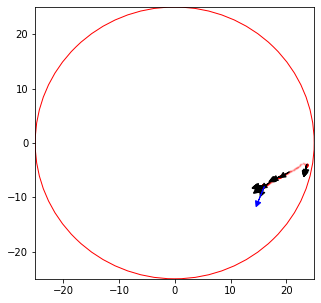

In [96]:
df_plot=pd.DataFrame(np.vstack((x_sub,y_sub,body_angle_sub)).T, 
columns=['x','y','angle'])
id = np.random.randint(df_plot.shape[0])
fig = display_trajectory(df_plot,index = id,past_memory=3*700)

# Parameters Tuning

### One euro filter

<font size="2">

The two parameters (fcmin and beta) can be set using a simple two-step procedure:
* First beta is set to 0 and fcmin (mincutoff) to a reasonable middle-ground value such as 1 Hz. Then the body part is held steady or moved at a very low speed while fcmin is adjusted to remove jitter and preserve an acceptable lag during these slow movements (decreasing fcmin reduces jitter but increases lag, fcmin must be > 0). 
* Next, the body part is moved quickly in different directions while beta is increased with a focus on minimizing lag. First find the right order of magnitude to tune beta, which depends on the kind of data you manipulate and their units: do not hesitate to start with values like 0.001 or 0.0001. You can first multiply and divide beta by factor 10 until you notice an effect on latency when moving quickly. 

Note that parameters fcmin and beta have clear conceptual relationships: if high speed lag is a problem, increase beta; if slow speed jitter is a problem, decrease fcmin.

</font>

In [97]:
from preprocessing.smoothing import one_euro_filter


In [98]:
# Find smooth epoch:
Duration = fps_new*5
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent<0.05:
        is_fish_stationnary=True


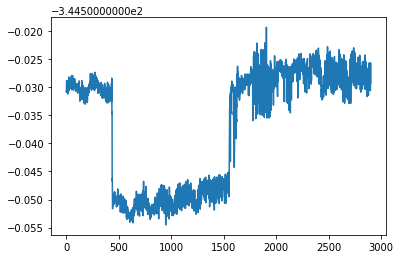

In [99]:

#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(-344.6307916563484, -344.43079165634833)

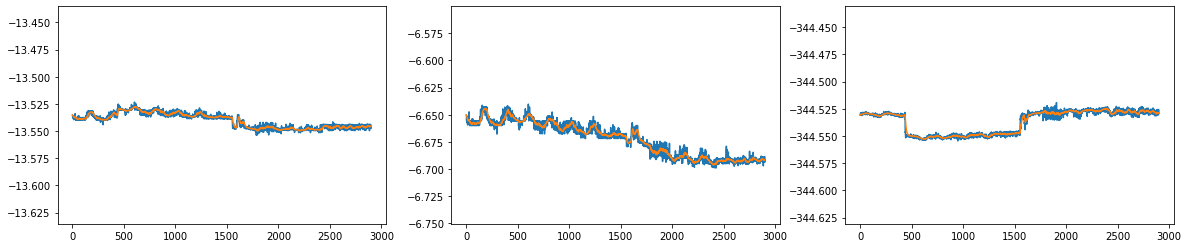

In [100]:
fc_min,beta = 10,0

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=0.1
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


In [101]:
# Find fast movement epoch:
Duration = int(np.round(fps_new*0.2))
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent>3:
        is_fish_stationnary=True

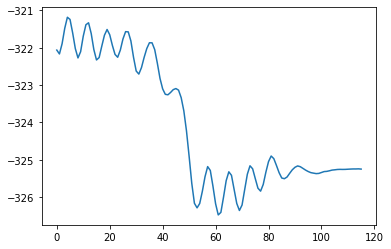

In [102]:
#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(-325.0643032541951, -319.0643032541951)

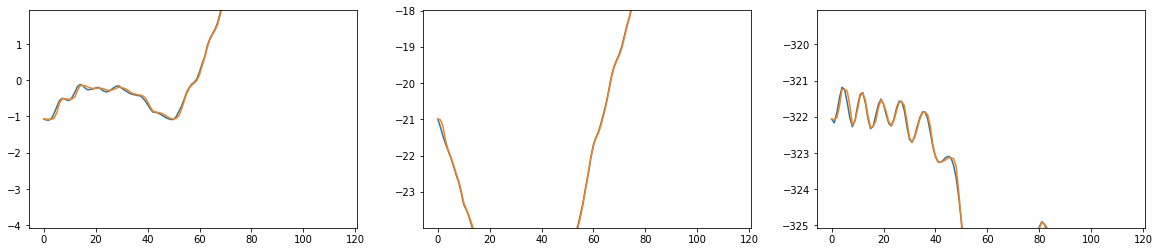

In [103]:
fc_min,beta = 10,4

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=3
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


## Peak Finding

In [104]:
from scipy.signal import find_peaks

In [105]:
cfg_preprocess = ConfigTrajPreprocess(fps=fps_new,freq_cutoff_min=10,beta=4)
cfg_segment_classify = ConfigTrajSegmentationClassification(fps=fps_new)

In [106]:
pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment_classify,load_training=False)

In [107]:
tracking_data = Dataset_CentroidTracking(fps=cfg_preprocess.fps,
                                         x=x_sub,
                                         y=y_sub,body_angle=body_angle_sub)
        
clean_traj = pipeline.preprocess(x=tracking_data.x,
                                 y=tracking_data.y,
                                 body_angle=tracking_data.body_angle)      

In [108]:

mobility = clean_traj.mobility

In [109]:
bout_duration = cfg_segment_classify.bout_duration
# Number of peak as function of prominence:
prom_para = np.linspace(0.01,0.4,100)
num_peaks = np.zeros_like(prom_para)
for i,pro in enumerate(prom_para):
    peaks, _ = find_peaks(mobility,distance=bout_duration,prominence=pro)
    num_peaks[i] = len(peaks)


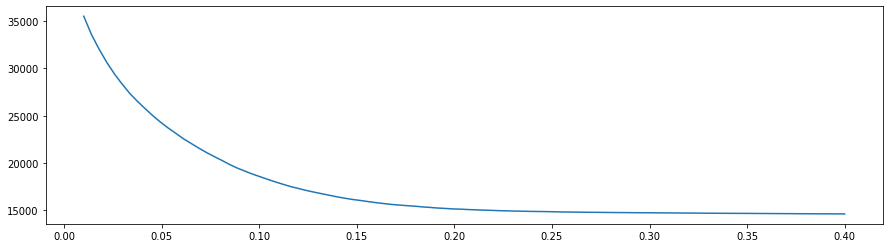

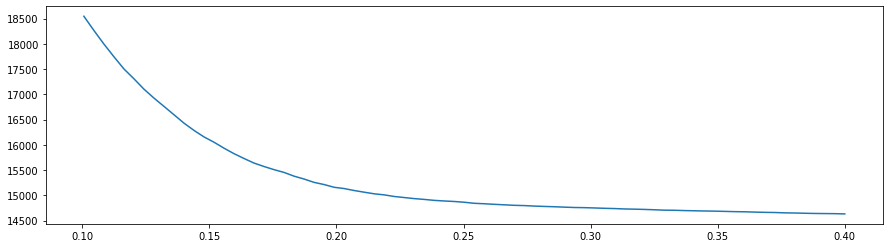

In [110]:
plt.figure(figsize=(15,4))
plt.plot(prom_para,num_peaks)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(prom_para[(prom_para>0.1)&(prom_para<2)],num_peaks[(prom_para>0.1)&(prom_para<2)])
plt.show()

In [111]:

fps_list = np.linspace(30,700,30)
fps_list = 10*np.round(fps_list/10).astype('int')

peak_prominence_list = np.linspace(0.1,1,30)

In [115]:
fps_list[24],peak_prominence_list[24]

(580, 0.8448275862068965)

# Run Pipeline

In [160]:
cfg_preprocess = ConfigTrajPreprocess(fps=fps_new,freq_cutoff_min=10,beta=4)
cfg_segment_classify = ConfigTrajSegmentationClassification(fps=fps_new,peak_prominence=0.84,margin_before_peak_ms=34,augment_max_delay_ms=34,augment_step_delay_ms=4,N_kNN=10)
pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment_classify,load_training=True)

In [161]:
tracking_data,clean_traj,segments,segment_refined,traj_array,bout_category,onset_delay,id_nearest_template = pipeline.run(x_sub,y_sub,body_angle_sub)

In [166]:
onset_super_res = segment_refined.onset
onset_super_res = np.array(onset_super_res)

In [167]:
delta_t = 50 
label_full = []
label_super = []

N_match = 0
for on_,cat_full in zip(onset_full,bout_cat_full):
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        id_super = np.argmin(np.abs(original_t[on_]-new_t[onset_super_res]))
        cat_super = bout_category[id_super]
        N_match = N_match+1
        label_full.append(cat_full)
        label_super.append(cat_super)
        
x = np.array(label_full)
y = np.array(label_super)

In [168]:
N_match/len(bout_cat_full)

0.9884808712650097

In [169]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x, y)

0.7751878187678932

In [170]:
balanced_accuracy_score(x%13, y%13)

0.8454954673190461

In [171]:
from sklearn.metrics import confusion_matrix


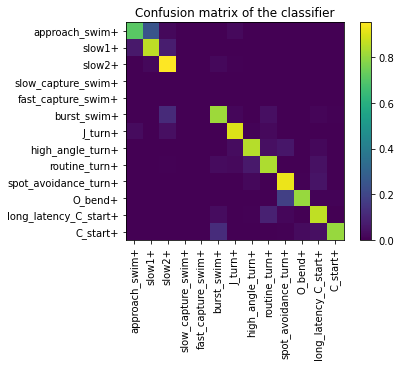

In [172]:

cm = confusion_matrix(x%13, y%13, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

### ALTERNATIVE INCLUDE BOTH SEGMENTATION AND CLASSIFICATION USING No_Mvt as an other category:

In [ ]:
#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=40,augment_step_delay_ms=4,N_kNN=5)
# 0.772, 0.843

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=28,augment_max_delay_ms=28,augment_step_delay_ms=4,N_kNN=5)
#0.764,0.841

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=34,augment_step_delay_ms=4,N_kNN=5)
# 0.775,0.844

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=34,augment_step_delay_ms=4,N_kNN=5)
# 0.772,0.842

# Check classification results

In [ ]:
N = len(segment_refined.onset)
i = np.random.randint(N)

on_ = segment_refined.onset[i] 
j = id_nearest_template[i]
Margin_Plot = 20

plt.figure(figsize=(10,4))
plt.plot(tracking_data.body_angle[on_-Margin_Plot:on_+200]-tracking_data.body_angle[on_])
plt.plot(clean_traj.body_angle[on_-Margin_Plot:on_+200]-clean_traj.body_angle[on_])
plt.plot(np.arange(140)+Margin_Plot,traj_array[i,2,:])
plt.plot(np.arange(140)+Margin_Plot,pipeline.knn_training_dataset.traj[j,2,:])
plt.ylim(-2,2)


In [ ]:
templates_labels = pipeline.knn_training_dataset.labels
print(traj_array.shape)

In [ ]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_category==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(traj_array[id,0,:].T,'k',alpha=0.05)

    ax0.set_xlim(0,cfg_segment_classify.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [ ]:

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(bout_category==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(traj_array[id,1,:].T,'k',alpha=0.05)

    ax0.set_xlim(0,cfg_segment_classify.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Compare with Matlab pipeline

In [ ]:
from utils.utils_bouts import compute_bout_cat_ts
from classification.benchmark_w_matlab import compute_bout_cat_matlab
from scipy import stats

In [ ]:
bout_cat_ts,bout_cat_ts_signed = compute_bout_cat_ts(segment_refined.onset,segment_refined.offset,bout_category,tracking_data.n_frames)


In [ ]:
onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df,fps_new=fps_new,fps_old=700)

label_mat = []
label_py = []

for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = bout_cat_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        label_py.append(stats.mode(tmp)[0][0])

In [ ]:
from sklearn.metrics import confusion_matrix
x = np.array(label_mat)
y = np.array(label_py)

cm = confusion_matrix(x, y, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [ ]:
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

In [ ]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)


* 0.49 with KNN 5 SCALE 0 0 2
* 0.68.5 with KNN 5 SCALE 0.4 0.4 2
* 0.68 with KNN 1 SCALE 0.4 0.4 2
* 0.69 with KNN 50 SCALE 0.4 0.4 2
* 0.723 with KNN 50 SCALE 0.4 0.4 2 Delay -10,20


In [ ]:
pipeline.knn_training_dataset.traj.shape

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

from utils.utils_plot import list_color_w_CS
cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)
cmp_bouts_pltly = matplotlib_to_plotly(cmp_bouts, 255)


In [ ]:

Duration = fps_new*7
IdSt = 7969693#
IdSt = np.random.randint(mobility.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/fps_new,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(segment_refined.onset,segment_refined.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_i = np.array(sub_i)

sub_traj_array = traj_array[sub_i,:,:]
id = id_nearest_template[sub_i]
traj_nearest = pipeline.knn_training_dataset.traj[id,:,:]

In [ ]:
tail_angle.shape
bout_duration = cfg_segment_classify.bout_duration

In [ ]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(8,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,tail_angle[IdSt:IdEd,7],lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[1])
ax.plot(t,tail_angle_sub[IdSt:IdEd,7],'k',lw=1)
#ax.plot(t,yaw_speed[IdSt:IdEd],lw=1)
#ax.plot(t,yaw_speed_hat_[IdSt:IdEd],lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[2])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[3])
ax.imshow(bout_cat_ts_matlab[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[4])
ax.plot(t,mobility[IdSt:IdEd])
#y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
#ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
#for p in sub_peaks:
#    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[5])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,0,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,0,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[6])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,1,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[7])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,2,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,2,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

# Compare Pipeline with Gold Standard

NameError: name 'compute_bout_cat_ts' is not defined

In [ ]:
pipeline_results_full_tracking.keys()

In [ ]:
onset_super_res = segment_refined.onset
onset_super_res = np.array(onset_super_res)

In [ ]:
len(original_t),len(new_t)

In [ ]:
len(pipeline_results_full_tracking['z'])

In [ ]:
original_t[-1]

### Segmentation accuracy

In [ ]:

delta_t = 50 # only if another onset is located at 50 ms
# onset_full

N_match = 0
for on_ in onset_full:
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        N_match = N_match+1
    
print(100*N_match/len(onset_full))

### Classification accuracy

In [ ]:

delta_t = 50 # only if another onset is located at 50 ms

label_full = []
label_super = []

N_match = 0
for on_,cat_full in zip(onset_full,bout_cat_full):
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        id_super = np.argmin(np.abs(original_t[on_]-new_t[onset_super_res]))
        cat_super = bout_category[id_super]
        
        label_full.append(cat_full)
        label_super.append(cat_super)

In [ ]:
#bout_cat_ts_super,bout_cat_ts_signed_super = compute_bout_cat_ts(segment_refined.onset,segment_refined.offset,bout_category,tracking_data.n_frames)


In [30]:
from sklearn.metrics import confusion_matrix


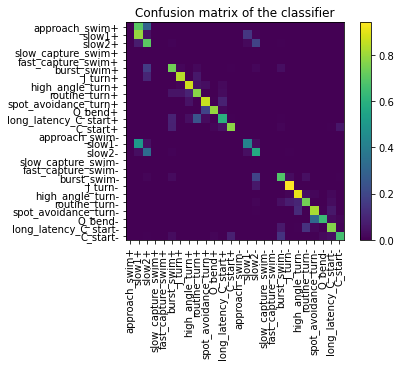

In [38]:
x = np.array(label_full)
y = np.array(label_super)

cm = confusion_matrix(x, y, labels = np.arange(26),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(26),NameCat,rotation=90)
plt.yticks(np.arange(26),NameCat,rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(x, y)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x, y)

In [ ]:
x_sym = x%13
y_sym = y%13

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_sym,y_sym)

In [ ]:

# Do you find the same label as in the original fps (classification accuracy)

In [ ]:

'''
segments = pipeline['segments']
bout_cat = pipeline['bout_cat']
tail_and_traj_array = pipeline['tail_and_traj_array']
tail_angle = pipeline['tail_angle_detrend']
onset_py = segments.onset
offset_py = segments.offset'''
break

# Save to Plotly

In [ ]:
t = np.arange(0,len(mobility))

fig = make_subplots(rows=3, cols=1,shared_xaxes=True)


for pl in px.imshow(bout_cat_signed.T, x=t, y=np.arange(2)).data:
    fig.add_trace(pl, row=1, col=1)

for pl in px.imshow(df.bout_cat_matlab.values[np.newaxis,:], x=t, y=np.arange(1)).data:
    fig.add_trace(pl, row=2, col=1)


fig.add_trace(go.Scatter(x=t, y=mobility,mode='lines'),
              row=3, col=1)

layout = px.imshow(bout_cat_signed.T,x= t,color_continuous_scale=cmp_bouts_pltly,zmin=-1,zmax=12).layout
fig.layout.coloraxis = layout.coloraxis

fig.update_traces(xaxis="x")

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("super_resolution_pipeline.html")
